Step 7: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product considering context generation

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates
#three user classes

In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],
             np.multiply([0.3, 0.3, 0.3, 0.3],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

Abbiamo implementato CG LEARNER ENVIRONMENT, PER I LEARNERS usiamo una lista di learners.
RESTA DA IMPLEMENTARE:
1. CAPIRE COME SCRIVERE L'ULTIMA PARTE DEI conversion_rates
2. CONFRONT TS E UCB


## TS AND UCB

In [9]:
#Context generation for TS and random (reset every 2 weeks)

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1_cr = 0
    split2_cr = 0

    split1_ts = 0
    split2_ts = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1_cr==0 and split2_cr==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learner.pull_arm()

                reward_cr = env.round(pulled_arm_cr)  #reward_cr[f1][f2][i]
                cr_learner.update(pulled_arm_cr[0][0] , reward_cr[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1_cr==1 and split2_cr==0:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm_cr[f1][0], (reward_cr[f1][0]+reward_cr[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_cr==1 and split2_cr==1:  # we add the second split
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_cr == 0 and split2_cr ==1:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm_cr[0][f2], (reward_cr[0][f2]+reward_cr[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # --------------------------------------------------
        # -------------------THOMSON SAMPLING ---------------
        # --------------------------------------------------
        #ciao

            if split1_ts==0 and split2_ts==0:
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                    ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                # FIRST DECISION
            if split1_ts==1 and split2_ts==0:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_ts==1 and split2_ts==1:  # we add the second split
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    for f2 in range(2):
                        ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_ts == 0 and split2_ts ==1:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f2 in range(2):
                    ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))




        # DECISION
        #compute sample probabilities and make decision
        if split1_cr==0 and split2_cr==0:
            mu_c0_cr[split1_cr][split2_cr] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0_cr=',mu_c0_cr)
             # split 1
            collected_reward_crs=np.concatenate((collected_reward_crs, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1_cr = 1
            split2_cr = 0

        elif split1_cr==1 and split2_cr==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            split2_cr = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1_cr = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1_cr = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_cr==1 and split2_cr==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0_cr=',mu_c0_cr)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[1][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_cr == 0 and split2_cr ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

        
            # DECISION
        #compute sample probabilities and make decision
        if split1_ts==0 and split2_ts==0:
            mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
            print('mu_c0_ts=',mu_c0_ts)
             # split 1
            collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
            #ts_learners = [ts_learner,ts_learner]
            ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
            split1_ts = 1
            split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            split2_ts = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                ts_learners = [[TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)] for _ in range(2)]
                split1_ts = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split1_ts = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0][0].collected_rewards +
                                              ts_learners[0][1].collected_rewards +
                                              ts_learners[1][0].collected_rewards +
                                              ts_learners[1][1].collected_rewards )
                                              ) #axis=None


            print('mu_c0_ts=',mu_c0_ts)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                ts_learners = [TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")




period 0
mu_c0_cr= [[960.1395304179421, 0], [0, 0]]
mu_c0_ts= [[1339.0646884707442, 0], [0, 0]]
period 1
p_c1*mu_c1 + p_c2*mu_c2= 888.8125339951229
mu_c0_cr= [[960.1395304179421, 0], [888.8125339951229, 0]]
--- SPLIT F1 DOESN'T MAKE SENSE ---
p_c1*mu_c1 + p_c2*mu_c2= 1788.894489976702
mu_c0_ts= [[1339.0646884707442, 0], [1788.894489976702, 0]]
--- SPLIT F1 MAKES SENSE ---
period 2
p_c1*mu_c1 + p_c2*mu_c2= 1287.0273541989438
mu_c0_cr= [[960.1395304179421, 1287.0273541989438], [888.8125339951229, 0]]
--- SPLIT F2 MAKES SENSE (without f1)---
mu_c0_ts= [[1339.0646884707442, 0], [1788.894489976702, 2106.433298716829]]
p_c1*mu_c1 + p_c2*mu_c2= 2106.433298716829
--- SPLIT F2 MAKES SENSE (together with f1)---
period 3
p_c1*mu_c1 + p_c2*mu_c2= 2836.928321281851
mu_c0_cr= [[960.1395304179421, 2836.928321281851], [888.8125339951229, 0]]
--- SPLIT F2 MAKES SENSE (without f1)---
mu_c0_ts= [[1339.0646884707442, 0], [1788.894489976702, 4329.3425783585535]]
p_c1*mu_c1 + p_c2*mu_c2= 4329.3425783585535


In [10]:
#SPlit finale
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 5
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    for d in range(300):
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])
                        collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[f1][f2].collected_rewards))

    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    


    for f1 in range(2):
            for f2 in range(2):
                for i in range(5):
                    conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                    opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
                conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

                mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
                cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)


opt = [[0 for _ in range(2)] for _ in range(2)]
opt2 = [[0 for _ in range(2)] for _ in range(2)]
for f1 in range(2):
    for f2 in range(2):
        opt[f1][f2] = np.mean(opt_vector[f1][f2]) #+ np.std(opt_vector)
        opt2[f1][f2] = np.min(opt_vector[f1][f2])


best_arm_per_product = [[np.zeros(5) for i in range(2)] for i in range(2)]
for f1 in range(2):
    for f2 in range(2):

        for i in range(5):   
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i] 
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#



In [11]:
for f1 in range(2):
    for f2 in range(2):
        print(best_arm_per_product[f1][f2])

[3. 3. 3. 3. 3.]
[0. 0. 0. 0. 0.]
[3. 3. 3. 3. 3.]
[0. 0. 0. 0. 0.]


In [12]:
opt, opt2

([[130.05906794738226, 0.0], [126.33212012970448, 93.30836726514966]],
 [[124.78862036558951, 0.0], [122.44067256203105, 92.32183405877048]])

In [23]:
#THOMPSON REWARD TOTALE (no reset)

np.random.seed(1000)
n_arms = 4
num_users = 1000
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ts_learner = TS_poisson(n_arms=n_arms)


    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ts = 0
    split2_ts = 0

    for d in range(int(n_days*3/14)):
        for d in range(14):

                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ts==0 and split2_ts==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                        reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                        ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                    # FIRST DECISION
                if split1_ts==1 and split2_ts==0:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)
                    P = env.E.users_by_class/np.sum(env.E.users_by_class)
                    p_c1 = P[0][0] + P[0][1]
                    p_c2 = P[1][0] + P[1][1]
                    for f1 in range(2):
                        ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]*p_c1+reward_ts[f1][1]*p_c2), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

                elif split1_ts==1 and split2_ts==1:  # we add the second split
 
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])


                elif split1_ts == 0 and split2_ts ==1:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f2 in range(2):
                        ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))


            # DECISION
        if split1_ts==0 and split2_ts==0:
                mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
                #print('mu_c0_ts=',mu_c0_ts)
                # split 1
                collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
                #ts_learners = [ts_learner,ts_learner]
                ts_learner1 = copy.deepcopy(ts_learner)
                ts_learner2 = copy.deepcopy(ts_learner)
                ts_learner1.reset()
                ts_learner2.reset()
                ts_learners = [ts_learner1,ts_learner2]
                split1_ts = 1
                split2_ts = 0

        elif (split1_ts==1 and split2_ts==0):
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ts = 1  # in ogni caso consideremo la seconds feature
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None
                
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:

                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner3 = copy.deepcopy(ts_learner)
                    ts_learner4 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learner3.reset()
                    ts_learner4.reset()
                    ts_learners = [[ts_learner1,ts_learner2],[ts_learner3,ts_learner4]]
                    split1_ts = 1
                    #print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1,ts_learner2]
                    split1_ts = 0
                    #print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:

                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0][0].collected_rewards*P[0][0] +
                                                ts_learners[0][1].collected_rewards*P[0][1] +
                                                ts_learners[1][0].collected_rewards*P[1][0] +
                                                ts_learners[1][1].collected_rewards*P[1][1] )
                                                ) #axis=None
                #print('mu_c0_ts=',mu_c0_ts)
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 >mu_c0_ts[1][0]:
                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learners[0][0])
                    ts_learner2 = copy.deepcopy(ts_learner[1][0])
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1 ,ts_learner2]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ts_learners = [TS_poisson(n_arms=n_arms)]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

    

In [7]:
OPT = opt[0][0] * 0.3 + opt[1][0]*0.4 + 0.3*opt[1][1]


In [8]:
OPT, np.mean(collected_reward_tss)

(50.01591959678362, 39.82927843305745)

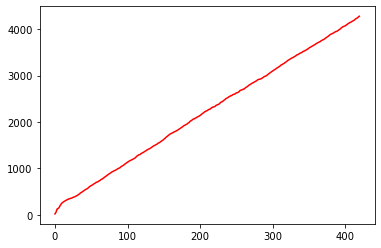

In [9]:
plt.plot(np.cumsum(OPT - collected_reward_tss, axis=0), 'r')

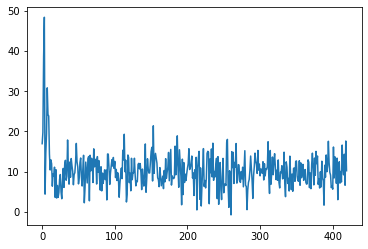

In [10]:
plt.plot(OPT - collected_reward_tss)

In [15]:
#UCB REWARD TOTALE (no reset)

np.random.seed(1000)
n_arms = 4
num_users = 1000
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_ucbs = np.array([])

mu_c0_ucb = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ucb_learner = UCB(n_arms=n_arms)


    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ucb = 0
    split2_ucb = 0

    for d in range(int(n_days*3/14)):
        for d in range(14):

                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ucb==0 and split2_ucb==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ucb[f1][f2] = ucb_learner.pull_arm( )

                        reward_ucb = env.round(pulled_arm_ucb)  #reward_ucb[f1][f2][i]
                        ucb_learner.update(pulled_arm_ucb[0][0] , reward_ucb[0][0])

                    # FIRST DECISION
                if split1_ucb==1 and split2_ucb==0:
                    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ucb[f1][f2] = ucb_learners[f1].pull_arm( )

                    reward_ucb = env.round(pulled_arm_ucb)
                    P = env.E.users_by_class/np.sum(env.E.users_by_class)
                    p_c1 = P[0][0] + P[0][1]
                    p_c2 = P[1][0] + P[1][1]
                    for f1 in range(2):
                        ucb_learners[f1].update(pulled_arm_ucb[f1][0], (reward_ucb[f1][0]*p_c1+reward_ucb[f1][1]*p_c2))

                elif split1_ucb==1 and split2_ucb==1:  # we add the second split
 
                    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ucb[f1][f2] = ucb_learners[f1][f2].pull_arm( )

                    reward_ucb = env.round(pulled_arm_ucb)

                    for f1 in range(2):
                        for f2 in range(2):
                            ucb_learners[f1][f2].update(pulled_arm_ucb[f1][f2], reward_ucb[f1][f2])


                elif split1_ucb == 0 and split2_ucb ==1:
                    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ucb[f1][f2] = ucb_learners[f2].pull_arm( )

                    reward_ucb = env.round(pulled_arm_ucb)

                    for f2 in range(2):
                        ucb_learners[f2].update(pulled_arm_ucb[0][f2], (reward_ucb[0][f2]+reward_ucb[1][f2]))


            # DECISION
        if split1_ucb==0 and split2_ucb==0:
                mu_c0_ucb[split1_ucb][split2_ucb] = np.sum(np.sum(ucb_learner.rewards_per_arm))
                #print('mu_c0_ucb=',mu_c0_ucb)
                # split 1
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs, ucb_learner.collected_rewards)) #axis=None
                #ucb_learners = [ucb_learner,ucb_learner]
                ucb_learner1 = copy.deepcopy(ucb_learner)
                ucb_learner2 = copy.deepcopy(ucb_learner)
                ucb_learner1.reset()
                ucb_learner2.reset()
                ucb_learners = [ucb_learner1,ucb_learner2]
                split1_ucb = 1
                split2_ucb = 0

        elif (split1_ucb==1 and split2_ucb==0):
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ucb_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ucb_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ucb = 1  # in ogni caso consideremo la seconds feature
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ucb=',mu_c0_ucb)
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs,
                                                    ucb_learners[0].collected_rewards*p_c1 + ucb_learners[1].collected_rewards*p_c2)) #axis=None
                
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ucb[0][0]:

                    ucb_learner1 = copy.deepcopy(ucb_learner)
                    ucb_learner2 = copy.deepcopy(ucb_learner)
                    ucb_learner3 = copy.deepcopy(ucb_learner)
                    ucb_learner4 = copy.deepcopy(ucb_learner)
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    ucb_learner3.reset()
                    ucb_learner4.reset()
                    ucb_learners = [[ucb_learner1,ucb_learner2],[ucb_learner3,ucb_learner4]]
                    split1_ucb = 1
                    #print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ucb_learner1 = copy.deepcopy(ucb_learner)
                    ucb_learner2 = copy.deepcopy(ucb_learner)
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    ucb_learners = [ucb_learner1,ucb_learner2]
                    split1_ucb = 0
                    #print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ucb==1 and split2_ucb==1:

                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ucb_learners[0][0].rewards_per_arm))+np.sum(np.sum(ucb_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ucb_learners[0][1].rewards_per_arm))+np.sum(np.sum(ucb_learners[1][1].rewards_per_arm))

                mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs,
                                                    ucb_learners[0][0].collected_rewards*P[0][0] +
                                                ucb_learners[0][1].collected_rewards*P[0][1] +
                                                ucb_learners[1][0].collected_rewards*P[1][0] +
                                                ucb_learners[1][1].collected_rewards*P[1][1] )
                                                ) #axis=None
                #print('mu_c0_ucb=',mu_c0_ucb)
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 >mu_c0_ucb[1][0]:
                    for f1 in range(2):
                        for f2 in range(2):
                            ucb_learners[f1][f2].reset()
                    mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ucb_learner1 = copy.deepcopy(ucb_learners[0][0])
                    ucb_learner2 = copy.deepcopy(ucb_learner[1][0])
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    ucb_learners = [ucb_learner1 ,ucb_learner2]
                    split2_ucb = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ucb == 0 and split2_ucb ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ucb_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ucb_learners[1].rewards_per_arm))

                mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ucb=',mu_c0_ucb)
                collected_reward_ucbs=np.concatenate((collected_reward_ucbs,
                                                    ucb_learners[0].collected_rewards*p_c1 + ucb_learners[1].collected_rewards*p_c2)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ucb[0][0]:
                    ucb_learner1.reset()
                    ucb_learner2.reset()
                    mu_c0_ucb[split1_ucb][split2_ucb] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ucb_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ucb_learners = [UCB(n_arms=n_arms)]
                    split2_ucb = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")



In [18]:
OPT, np.mean(collected_reward_tss), np.mean(collected_reward_ucbs)

(50.01591959678362, 39.82927843305745, 42.48862339277756)

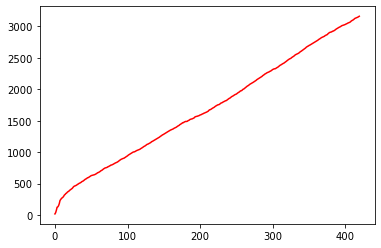

In [20]:
plt.plot(np.cumsum(OPT - collected_reward_ucbs, axis=0), 'r')

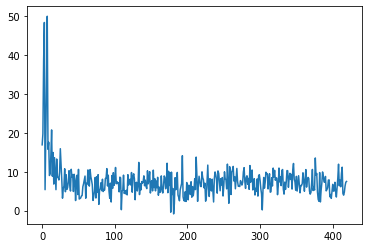

In [16]:
plt.plot(OPT - collected_reward_ucbs)